# PREPROCESSING

## Load data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import norm
import random as rand
import pickle
import re
from itertools import groupby
from operator import itemgetter

# Environment settings
data_path = 'Data/'
    
# Deserialize previously saved data from "data-visualization"
dataframes = {}
for df_name in ['test', 'train']:
    with open(data_path+df_name+'_dv.obj', 'rb') as file:
        dataframes[df_name] = pickle.load(file)

## Preprocess

In [2]:
# Remove useless columns
for df_name, df in dataframes.items():
    dataframes[df_name] = df.drop(['Ticket','Cabin'], axis=1)

In [3]:
# Transform category data into numerical
# hack for seaborn heatmap (no support for categorical values)
for df_name, df in dataframes.items():
    df['Sex'] = [0 if x == 'male' else 1 for x in df['Sex']]
    
# One hot encoding for Embark
for df_name, df in dataframes.items():
    f_df = pd.get_dummies(dataframes[df_name][['Embarked']], drop_first=True)
    dataframes[df_name].drop(['Embarked'], axis=1, inplace=True)
    dataframes[df_name] = pd.concat([dataframes[df_name], f_df], axis=1)

Number of missing 'Age' points in training set 0
Number of missing 'Age' points in test set 0


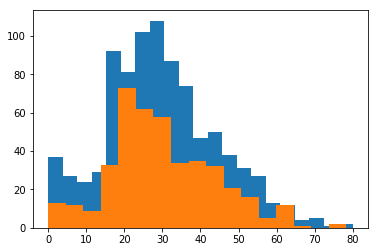

In [4]:
# Replace Age missing values with data generated from gaussian
np.random.seed(666)
for df_name, df in dataframes.items():
    # create gaussian with available da
    nan_filter = df['Age'].isna()
    mu, sigma = norm.fit(df[-nan_filter]['Age'])
    norm_dist = np.random.normal(mu, sigma, nan_filter.sum())
    df.loc[nan_filter,'Age'] = norm_dist
    
    # set to zero all ages below zero
    df.loc[df.Age<0, 'Age'] = 0

# Plot histogram of the gaussian distribution of the age
plt.hist(dataframes['train']['Age'], bins='auto')
plt.hist(dataframes['test']['Age'], bins='auto')
print("Number of missing 'Age' points in training set {}".format(dataframes['train']['Age'].isna().sum()))
print("Number of missing 'Age' points in test set {}".format(dataframes['test']['Age'].isna().sum()))

/home/flaprimo/Development/Workspaces/Python/titanic-classification/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


152    3
Name: Pclass, dtype: category
Categories (3, object): [1, 2, 3]
Number of missing 'Fare' points is in test set 0


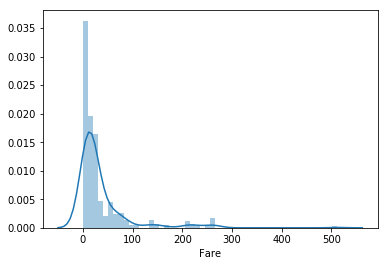

In [5]:
# Replace Fare missing values in test set with data generated from gaussian
sns.distplot(dataframes['test']['Fare'][~np.isnan(dataframes['test']['Fare'])]);

# Group fare by class
grouped = dataframes['test'].groupby('Pclass').mean()
grouped_fare = grouped['Fare']

# Get row (1 row in this case) that has missing value
nan_filter = dataframes['test']['Fare'].isna()
print(dataframes['test'].loc[nan_filter,'Pclass'])

# Since the missing value comes from a third class passenger, replace missing value
# with mean of third class fares
dataframes['test'].loc[nan_filter,'Fare'] = grouped_fare[2]
print("Number of missing 'Fare' points is in test set {}".format(dataframes['test']['Fare'].isna().sum()))

In [6]:
# Normalize Fares
max_fare = max(dataframes['train']['Fare'].max(), dataframes['test']['Fare'].max())
for df_name, df in dataframes.items():
    dataframes[df_name]['Fare'] = df['Fare'].apply(lambda fare: fare/max_fare)

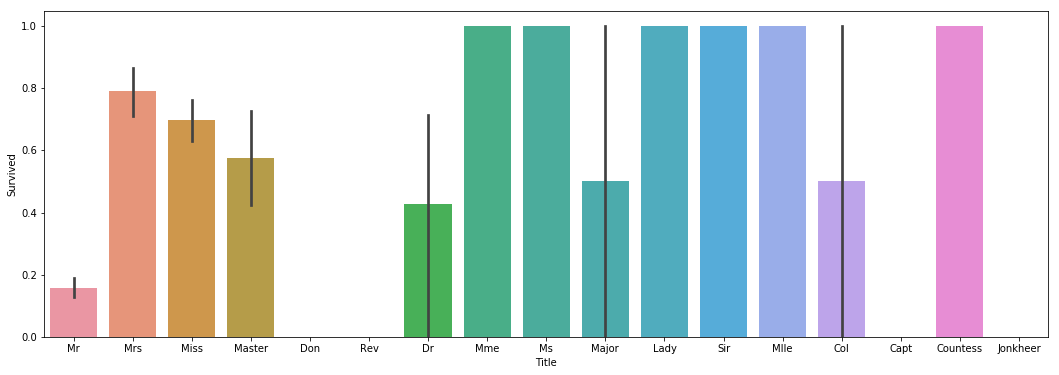

In [7]:
# Create a new feature Title which contains titles from Names
for df_name, df in dataframes.items():
    df['Title'] = df['Name'].apply(lambda name: re.search(' ([A-Za-z]+)\.', name).group(1))
    dataframes[df_name] = df.drop(['Name'], axis=1) # drop Name which is not useful anymore

fig, (axis1) = plt.subplots(1,figsize=(18,6))
sns.barplot(x='Title', y='Survived', data=dataframes['train'], ax=axis1)

# get titles with corresponding survival rate
title_survival = dataframes['train'][['Title', 'Survived']].groupby(['Title'], as_index=False) \
.mean().sort_values(by='Survived', ascending=False).values

# round values and change tuple key
title_survival = list(map(lambda x: (round(x[1], 1), x[0]), title_survival))
# hack for a single woman with title 'Dona' which is only present in the test set
# it is marked as surviving since women have larger chance to survive wrt to men
title_survival.insert(0, (1.0, 'Dona'))

# group titles by occurrency rate
title_survival_grouped = \
[(k, list(list(zip(*g))[1])) for k, g in groupby(title_survival, itemgetter(0))]

# get to categorical class mapper
i = 0
title_survival_categorical = list()
for x in title_survival_grouped:
    title_survival_categorical.append((i, x[1]))
    i += 1

# convert Title in train and test dataframes to categorical
for df_name, df in dataframes.items():
    for key, titles in title_survival_categorical:
        df['Title'] = df['Title'].replace(titles, key)

## Save data

In [8]:
# Serialize dataframes for later use in implementations
for df_name, df in dataframes.items():
    with open(data_path+df_name+'_pp.obj', 'wb') as file:
        pickle.dump(df, file)